**Problem Set #1**

Computational Astrodynamics (ΥΦΥ204)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Problem 1

## Exercise 1.1

Let us first study the Molniya orbit as defined by the problem statement. We are given the inclination ($i=63.4^{\circ}$) and the eccentricity ($e=0.64$). Using the pre-defined period of the orbit ($T=12\: hours=43200\:seconds$), we can derive the semi-major axis of the orbit using Kepler's third law:

$$ 
\begin{split}
T^{2} &=\frac{4 \pi^{2}}{\mu} a^{3} \\
\Rightarrow a^{3} &=\frac{T^{2}\mu}{4\pi^{2}} \\ 
\Rightarrow a^{3} &=\frac{T^{2}G(M_{earth}+M_{satellite})}{4\pi^{2}} \\
\Rightarrow a^{3} &\approx \frac{T^{2}G(M_{earth})}{4\pi^{2}}
\end{split}
$$

and using the values $G=6.6743\times10^{-11} \frac{kg m^{3}}{s^{2}kg^{2}}$ and $M_{earth}=5.977\times10^{24}kg$ we get:

$$
\begin{split}
a &= 26617396\:m \\
\Rightarrow a &= 26617.396\:km
\end{split}
$$

Considering that for $t=\tau=0$ the line of the nodes coincides with OY axis of the ICRF reference frame and that the apogee of the orbit points towards the first point of aries (point $\gamma$), we can determine that $\Omega=270^{\circ}$ and $\omega=270^{\circ}$. If we also take into account that for $t=\tau=0$ the satellite finds itself at the perigee of the orbit, we can also determine that the mean anomaly is $M_{initial}=0$. We also note that the mean anomaly is given by the following equation:

$$
\begin{split}
M &= n(t-\tau) \\
\Rightarrow Μ &= \frac{360^{\circ}}{T}(t-\tau) 
\end{split}
$$

The orbital elements of the Molniya orbit for $t=0$ can be summarized below:

|         Orbital Element         |     Value     |
|:-------------------------------:|:-------------:|
|         Semi-major axis         |  26617396 m   |
|           Eccentricity          |     $0.64$    |
|           Inclination           |     $63.4$    |
| Longitude of the ascending node | $270^{\circ}$ |
|      Argument of pericenter     | $270^{\circ}$ |
|           Mean anomaly          | $0^{\circ}$ |

While the code for the tranformation $F:(a, e, i, \Omega, \omega, M) \rightarrow(\boldsymbol{R}, \dot{\boldsymbol{R}})$ from orbital elements to cartesian coordinates and speeds can be found below:

In [1]:
import numpy as np
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# Silent run for NaNs 
import warnings
warnings.filterwarnings('ignore')

def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector
    
    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    elif M > np.pi:
        E_0 = M + e
    else:
        E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E : M-E+np.sin(E)
    fdot = lambda E : -1+np.cos(E)
    # Stopping criteria 
    N = 10  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev)/fdot(E_prev))
        ea = np.fabs((E_next-E_prev)*100/E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            #print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next  
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu/pow(a, 3)) # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega),-np.sin(omega),0],
                   [np.sin(omega),np.cos(omega),0],
                   [0,0,1]])
    P2 = np.array([[1,0,0],
                   [0,np.cos(i),np.sin(i)],
                   [0,np.sin(i),np.cos(i)]])
    P3 = np.array([[np.cos(Omega),-np.sin(Omega),0],
                   [np.sin(Omega),np.cos(Omega),0],
                   [0,0,1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x,y,0])
    x_y_dot_vector = np.array([x_dot,y_dot,0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_dot_vector)
    return(r_vector, v_vector)


# Orbit definition

a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter
M = 0  # Mean Anomaly

# System properties 

G = 6.6743*pow(10,-11)
M_earth = 5.977*pow(10,24)
mu = G*M_earth

# Orbital elements -> Cartesian
r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)


## Exercise 1.2

Let us now write a script to complete the opposite transformation, namely $F^{-1}:(\boldsymbol{R}, \dot{\boldsymbol{R}}) \rightarrow(a, e, i, \Omega, \omega, M)$. We will also assign some random values to our orbital elements to determine the accuracy of both of our transformations. The code for the cartesian elements to orbital elements transformation can be found below:

In [2]:
import numpy as np
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# Silent run for NaNs 
import warnings
warnings.filterwarnings('ignore')

def cartesian_to_orbital_elements(r_vector, v_vector, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # r_vector, y_vector
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # a [m] (Semi-major axis)
    # e [] (Eccentricity)
    # i [deg] (Inclination)
    # Omega [deg] (Longitude of the ascending node)
    # omega [deg] (Argument of pericenter)
    # ni [deg] (True anomaly)
    # M [deg] (Mean anomaly)
    
    # Compute magnitude and angular momentum
    r = np.sqrt(pow(r_vector[0], 2) + pow(r_vector[1], 2) + pow(r_vector[2], 2))
    v = np.sqrt(pow(v_vector[0], 2) + pow(v_vector[1], 2) + pow(v_vector[2], 2))
    h_vector = np.cross(r_vector, v_vector)
    h = np.sqrt(pow(h_vector[0], 2) + pow(h_vector[1], 2) + pow(h_vector[2], 2))
    # Compute a, e and i
    a = mu/((2*mu/r) - pow(v, 2))
    e = np.sqrt(1-(pow(h, 2)/(mu*a)))
    i = np.arccos(h_vector[2]/h)
    # Compute Omega (Longitude of the Ascending Node)
    if h_vector[2] > 0:
        sin_Omega = h_vector[0] / (h * np.sin(i))
        cos_Omega = - h_vector[1] / (h * np.sin(i))
    else:
        sin_Omega = - h_vector[0] / (h * np.sin(i))
        cos_Omega = h_vector[1] / (h * np.sin(i))
    if sin_Omega >= 0:
        Omega = np.arccos(cos_Omega)
    else:
        Omega = 2*np.pi - np.arccos(cos_Omega)
    # Compute E
    cos_E = (a-r)/(a*e)
    sin_E = np.dot(r_vector, v_vector) / (e * np.sqrt(mu*a))
    # Compute true anomaly
    cos_ni = (cos_E - e) / (1 - (e * cos_E))
    sin_ni = (np.sqrt(1 - pow(e, 2)) * sin_E) / (1 - (e * cos_E))
    if sin_ni >= 0:
        ni = np.arccos(cos_ni)
    else:
        ni = 2*np.pi - np.arccos(cos_ni)
    # Compute mean anomaly
    if sin_E >= 0:
        E = np.arccos(cos_E)
    else:
        E = 2*np.pi - np.arccos(cos_E)
    M = E - e*sin_E
    # Compute omega (argument of pericenter)
    sin_omega_plus_ni = r_vector[2] / (r * np.sin(i))
    cos_omega_plus_ni = ((r_vector[0] * cos_Omega) + (r_vector[1] * sin_Omega))/r
    if  sin_omega_plus_ni >= 0:
        omega = np.arccos(cos_omega_plus_ni) - ni
    else:
        omega = 2*np.pi - np.arccos(cos_omega_plus_ni) - ni
    
    # Convert to degrees
    i = np.degrees(i)
    Omega = np.degrees(Omega)
    ni = np.degrees(ni)
    M = np.degrees(M)
    omega = np.degrees(omega)
    return(a, e, i, Omega, omega, ni, M)

# Transformation accuracy investigation

a = np.zeros((4,2))
e = np.zeros((4,2))
i = np.zeros((4,2))
Omega = np.zeros((4,2))
omega = np.zeros((4,2))
M = np.zeros((4,2))

# Case 1

# Orbit definition
row = 0
a[row][0] = 26617396  # Semi-major axis
e[row][0] = 0.64  # Eccentricity
i[row][0] = 63.4  # Inclination
Omega[row][0] = 270  # Longitude of the Ascending Note
omega[row][0] = 270  # Argument of pericenter
M[row][0] = 0  # Mean Anomaly

# F and F^-1 transformations 
r_vector, v_vector = orbital_elements_to_cartesian(a[row][0], e[row][0], i[row][0] , Omega[row][0], omega[row][0],  M[row][0], mu)
a[row][1], e[row][1], i[row][1] , Omega[row][1], omega[row][1], ni, M[row][1] = cartesian_to_orbital_elements(r_vector, v_vector, mu)

# Case 2

# Orbit definition
row = 1
a[row][0] = 26617396  # Semi-major axis
e[row][0] = 0.64  # Eccentricity
i[row][0] = 63.4  # Inclination
Omega[row][0] = 270  # Longitude of the Ascending Note
omega[row][0] = 270  # Argument of pericenter
M[row][0] = 90  # Mean Anomaly

# F and F^-1 transformations 
r_vector, v_vector = orbital_elements_to_cartesian(a[row][0], e[row][0], i[row][0] , Omega[row][0], omega[row][0],  M[row][0], mu)
a[row][1], e[row][1], i[row][1] , Omega[row][1], omega[row][1], ni, M[row][1] = cartesian_to_orbital_elements(r_vector, v_vector, mu)

# Case 3

# Orbit definition
row = 2
a[row][0] = 26617396  # Semi-major axis
e[row][0] = 0.64  # Eccentricity
i[row][0] = 63.4  # Inclination
Omega[row][0] = 270  # Longitude of the Ascending Note
omega[row][0] = 270  # Argument of pericenter
M[row][0] = 180  # Mean Anomaly

# F and F^-1 transformations 
r_vector, v_vector = orbital_elements_to_cartesian(a[row][0], e[row][0], i[row][0] , Omega[row][0], omega[row][0],  M[row][0], mu)
a[row][1], e[row][1], i[row][1] , Omega[row][1], omega[row][1], ni, M[row][1] = cartesian_to_orbital_elements(r_vector, v_vector, mu)

# Case 4

# Orbit definition
row = 3
a[row][0] = 26617396  # Semi-major axis
e[row][0] = 0.64  # Eccentricity
i[row][0] = 63.4  # Inclination
Omega[row][0] = 270  # Longitude of the Ascending Note
omega[row][0] = 270  # Argument of pericenter
M[row][0] = 270  # Mean Anomaly

# F and F^-1 transformations 
r_vector, v_vector = orbital_elements_to_cartesian(a[row][0], e[row][0], i[row][0] , Omega[row][0], omega[row][0],  M[row][0], mu)
a[row][1], e[row][1], i[row][1] , Omega[row][1], omega[row][1], ni, M[row][1] = cartesian_to_orbital_elements(r_vector, v_vector, mu)
    
print('Accuracy investigation:\n')
for counter in range (0,4):
    print('Case %d' % counter)
    print('==================================================')
    print('Quantity\tInitial\t\t\tFinal')
    print('a\t\t%d\t\t%d' % (a[counter][0],a[counter][1]))
    print('e\t\t%.10f\t\t%.10f' % (e[counter][0],e[counter][1]))
    print('i\t\t%.10f\t\t%.10f' % (i[counter][0],i[counter][1]))
    print('Ω\t\t%.10f\t\t%.10f' % (Omega[counter][0],Omega[counter][1]))
    print('ω\t\t%.10f\t\t%.10f' % (omega[counter][0],omega[counter][1]))
    print('M\t\t%.10f\t\t%.10f' % (M[counter][0],M[counter][1]))
    print('\n')

Accuracy investigation:

Case 0
Quantity	Initial			Final
a		26617396		26617396
e		0.6400000000		0.6400000000
i		63.4000000000		63.4000000000
Ω		270.0000000000		270.0000000000
ω		270.0000000000		270.0000000726
M		0.0000000000		0.0000004616


Case 1
Quantity	Initial			Final
a		26617396		26617395
e		0.6400000000		0.6400000000
i		63.4000000000		63.4000000000
Ω		270.0000000000		270.0000000000
ω		270.0000000000		-90.0000000000
M		90.0000000000		105.2447251803


Case 2
Quantity	Initial			Final
a		26617396		26617396
e		0.6400000000		0.6400000000
i		63.4000000000		63.4000000000
Ω		270.0000000000		270.0000000000
ω		270.0000000000		-90.0000000000
M		180.0000000000		180.0000000000


Case 3
Quantity	Initial			Final
a		26617396		26617396
e		0.6400000000		0.6400000000
i		63.4000000000		63.4000000000
Ω		270.0000000000		270.0000000000
ω		270.0000000000		-90.0000000000
M		270.0000000000		254.7552748197




We note that our transformations produce sufficient results overall, with the exception of the mean anomaly which appears to be sufferinf from some numerical errors (since it is directly calculated from the eccentric anomaly which is calculated directly from the eccentric anomaly). 

## Exercise 1.3

We will now make a 3D plot of our orbit. The code used for the animation can be seen below and saves the animation as an .mp4 file locally. Since Jupyter Notebooks have trouble rendering these animations, the animation can be viewed by [browsing this link](https://www.youtube.com/watch?v=QHWP-BoPzMU).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# Silent run for NaNs 
import warnings
warnings.filterwarnings('ignore')


def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector

    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    else:
        E_0 = M + e
    #else:
    #    E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E: M - E + np.sin(E)
    fdot = lambda E: -1 + np.cos(E)
    # Stopping criteria
    N = 20  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev) / fdot(E_prev))
        ea = np.fabs((E_next - E_prev) * 100 / E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            # print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu / pow(a, 3))  # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega), -np.sin(omega), 0],
                   [np.sin(omega), np.cos(omega), 0],
                   [0, 0, 1]])
    P2 = np.array([[1, 0, 0],
                   [0, np.cos(i), np.sin(i)],
                   [0, np.sin(i), np.cos(i)]])
    P3 = np.array([[np.cos(Omega), -np.sin(Omega), 0],
                   [np.sin(Omega), np.cos(Omega), 0],
                   [0, 0, 1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x, y, 0])
    x_y_dot_vector = np.array([x_dot, y_dot, 0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_dot_vector)
    return (r_vector, v_vector)


# Orbit definition

a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter
M = 0  # Mean Anomaly

# System properties

G = 6.6743 * pow(10, -11)
M_earth = 5.977 * pow(10, 24)
mu = G * M_earth
T = 43200

# Orbital elements -> Cartesian
r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)

size = 1080
x_values = np.zeros(size)
y_values = np.zeros(size)
z_values = np.zeros(size)
t_values = np.zeros(size)
for counter in range(0, size):
    M = counter  # Mean Anomaly
    r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)
    x_values[counter] = r_vector[0]
    y_values[counter] = r_vector[1]
    z_values[counter] = r_vector[2]
    t_values[counter] = M * T / 360

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-2e7,2e7))
ax.set_ylim((-2e7,2e7))
ax.set_zlim((-2e7,4e7))
ax.tick_params(labelsize=8)
ax.set_xlabel('X [m]', fontsize=12)
ax.set_ylabel('Y [m]', fontsize=12)
ax.set_zlabel('Z [m]', fontsize=12)
satellite, = plt.plot([],[],[], marker='o', color='tab:orange', label='Satellite')
traj, = plt.plot([],[],[], color='tab:red', alpha=0.5)
ax.scatter(0, 0, 0, color='tab:blue', marker='o', label='Earth', s=100)
the_string = "time"
time_text = ax.text(s='',x=3.5e7,y=4e7,z=0, fontdict=None)
ax.legend()
plt.title('3D View of the Molniya orbit\n\n')
ax.view_init(40, 29)

def init():
    time_text.set_text('')
    return time_text

def update(value):
    satellite.set_data(x_values[value],y_values[value])
    traj.set_data(x_values[:value+1],y_values[:value+1])
    satellite.set_3d_properties(z_values[value], 'z')
    traj.set_3d_properties(z_values[:value+1], 'z')
    time_text.set_text('t = ' + str(t_values[value]) +(' sec'))
    return satellite,traj, time_text

ani = animation.FuncAnimation(fig, update, frames=size, interval=1, init_func=init)
writer=animation.writers['ffmpeg'](fps=25)
plt.ioff()
dpi = 500
ani.save('3D_molniya_orbit_retselis.mp4',writer=writer,dpi=dpi)

## Exercise 1.4

Next we shall investigate the relative shift of frequency for a ground station receiving the signal of the satellite as a function of time. Assuming that the ground station is stationary, we can use the formula of the Doppler effect to solve the problem, namely:

$$
\Delta f = \frac{\Delta v}{c}
$$

and considering that $v_{r}=0$ we get

$$
\Delta f = \frac{v_s}{c}
$$

where $v_s$ is the radial component of the satellite's velocity. To compute the radial component of the satellite's velocity, we can use the following formula:

$$
v_{r}=\frac{\mu}{h} e \sin \nu
$$

where $h$ is the angular momentum and $\nu$ is the true anomaly. We can compute this shift at specific points throughout the orbit and plot the output. The code for this has been implemented below:

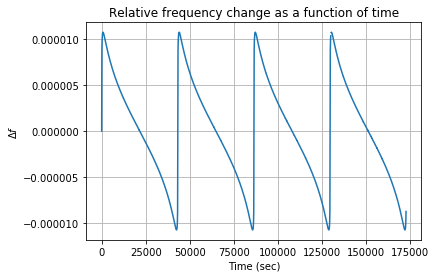

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# Silent run for NaNs 
import warnings
warnings.filterwarnings('ignore')

def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector

    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    elif M > np.pi:
        E_0 = M + e
    else:
        E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E: M - E + np.sin(E)
    fdot = lambda E: -1 + np.cos(E)
    # Stopping criteria
    N = 10  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev) / fdot(E_prev))
        ea = np.fabs((E_next - E_prev) * 100 / E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            # print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu / pow(a, 3))  # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega), -np.sin(omega), 0],
                   [np.sin(omega), np.cos(omega), 0],
                   [0, 0, 1]])
    P2 = np.array([[1, 0, 0],
                   [0, np.cos(i), np.sin(i)],
                   [0, np.sin(i), np.cos(i)]])
    P3 = np.array([[np.cos(Omega), -np.sin(Omega), 0],
                   [np.sin(Omega), np.cos(Omega), 0],
                   [0, 0, 1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x, y, 0])
    x_y_dot_vector = np.array([x_dot, y_dot, 0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1), x_y_dot_vector)
    return (r_vector, v_vector)

def doppler_shift(a, e, i , Omega, omega, M, mu, T, tau):
    # Makes a plot of Delta f over a time interval of 5 orbits
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # T (sec)
    # tau (sec)
    # Output:
    # None (returns a plot)
    
    # Initialize variables
    size = 1440
    Df_f = np.zeros(size)
    t_values = np.zeros(size)
    # Main calculation loop
    for counter in range(0, size):
        c = 3 * pow(10, 8)
        M = counter * 1  # Mean Anomaly
        t_values[counter] = (M / (360 / T)) + tau
        r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)
        h_vector = np.cross(r_vector, v_vector)
        h = np.sqrt(pow(h_vector[0], 2) + pow(h_vector[1], 2) + pow(h_vector[2], 2))
        r = np.sqrt(pow(r_vector[0], 2) + pow(r_vector[1], 2) + pow(r_vector[2], 2))
        # Compute E
        cos_E = (a - r) / (a * e)
        sin_E = np.dot(r_vector, v_vector) / (e * np.sqrt(mu * a))
        # Compute true anomaly
        sin_ni = (np.sqrt(1 - pow(e, 2)) * sin_E) / (1 - (e * cos_E))
        Df_f[counter] = (mu / h) * e * sin_ni / c
    # Plot results
    plt.figure()
    plt.plot(t_values, Df_f)
    plt.ylabel(r'$\Delta f$')
    plt.xlabel('Time (sec)')
    plt.title('Relative frequency change as a function of time')
    plt.grid()
    plt.show()


a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter
M = 0  # Mean Anomaly
tau = 0
T = 43200
G = 6.6743*pow(10,-11)
M_earth = 5.977*pow(10,24)
mu = G*M_earth

doppler_shift(a, e, i , Omega, omega, M, mu, T, tau)

## Exercise 1.5

Next we are asked to investigate the useful range of the spacecraft, which is defined as the time for which the satellite is at an angular distance of:

$$
\delta v=\pm \pi / 3
$$

from the orbit's apogee. The range shall be computed for two different eccentricity values, namely $e=0.64$ and $e=0.74$. For this problem, we basically have to compute the time of flight between two points for a given orbit. Specifically, since we have the true anomaly of the two points we can first compute the eccentric anomaly from the following formulas for each point:

$$
\begin{split}
\cos E &=\frac{e+\cos \nu}{1+e \cos \nu} \\
\sin E &=\frac{\sqrt{1-e^{2}} \sin \nu}{1+e \cos \nu}
\end{split}
$$

and then we can compute the time at each point using the following formula:

$$
t=\tau+\sqrt{a^{3} / \mu}(E-e \sin E)
$$

We can then compute the time of flight by subtracting the two time values. The above mentioned procedure is implemented as a script below:

In [4]:
import numpy as np

def time_between_points(n1, n2, e, a, mu, tau):
    # Computes flight time between two points
    # Input:
    # n1 [rad]
    # n2 [rad]
    # e []
    # a [m]
    # mu [m^3/(kg*s^2)] (GM)
    # tau [sec]
    # Output:
    # Flight time in seconds
    
    # Compute eccentric anomaly
    cos_E1 = (e + np.cos(n1))/(1+(e*np.cos(n1)))
    sin_E1 = (np.sqrt(1-pow(e,2))*np.sin(n1))/(1+(e*np.cos(n1)))
    if sin_E1 >= 0:
        E1 = np.arccos(cos_E1)
    else:
        E1 = 2*np.pi - np.arccos(cos_E1)
    cos_E2 = (e + np.cos(n2))/(1+(e*np.cos(n2)))
    sin_E2 = (np.sqrt(1-pow(e,2))*np.sin(n2))/(1+(e*np.cos(n2)))
    if sin_E2 >= 0:
        E2 = np.arccos(cos_E2)
    else:
        E2 = 2*np.pi - np.arccos(cos_E2)
    # Compute flight times    
    t2 = tau + np.sqrt(pow(a, 3)/mu)*(E2-e*np.sin(E2))
    t1 = tau + np.sqrt(pow(a, 3)/mu)*(E1-e*np.sin(E1))
    # Decide based on n1 and n2
    if(t2>=t1):
        return(t2-t1)
    else:
        E3 = 2*np.pi
        t3 = tau + np.sqrt(pow(a, 3)/mu)*(E3-e*np.sin(E3))
        return(t3-t1+t2)                                        

tau = 0
a = 26617396
G = 6.6743 * pow(10, -11)
M_earth = 5.977 * pow(10, 24)
mu = G * M_earth
                                               
delta_n = np.pi/3
apogee = np.pi
n1 = apogee-delta_n
n2 = apogee+delta_n

# Case 1 (e=0.64)
e = 0.64
result = time_between_points(n1, n2, e, a, mu, tau)
print('For e = %.2f flight time between the two points (or the useful range) is %.2f seconds.' % (e, result))

# Case 2 (e=0.74)
e = 0.74
result = time_between_points(n1, n2, e, a, mu, tau)
print('For e = %.2f flight time between the two points (or the useful range) is %.2f seconds.' % (e, result))

For e = 0.64 flight time between the two points (or the useful range) is 33063.57 seconds.
For e = 0.74 flight time between the two points (or the useful range) is 36382.67 seconds.


We note that the spacecraft spends the majority of an orbit inside this useful range, which highlights the benefit of the Molniya orbit for telecommunication purposes.

## Exercise 1.6

Finally, the orbit is to be converted to geographical coordinates so that we can plot the orbit over a 2D map of the earth. By doing this, we can also compute the latitude coverage range for our orbit. The code that performs both of these tasks can be seen below:

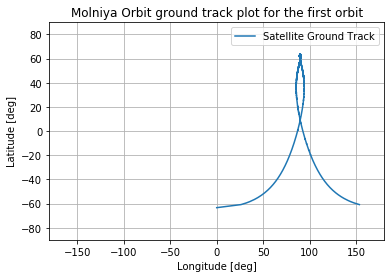

Latitude coverage range is [-63.40, 63.40]


In [5]:
import numpy as np
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# Silent run for NaNs 
import warnings
warnings.filterwarnings('ignore')

def orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu):
    # Computes cartesian position and velocity vector given some orbital elements
    # Input:
    # a [m]
    # e []
    # i [deg]
    # Omega [deg]
    # omega [deg]
    # M [deg]
    # mu [m^3/(kg*s^2)] (GM)
    # Output:
    # r_vector, y_vector
    
    # Compute E using Newton-Raphson
    # Define initial value for E_0
    if M > -np.pi and M < 0:
        E_0 = M - e
    elif M > np.pi:
        E_0 = M + e
    else:
        E_0 = 0.1
    # Convert M to radians
    M = np.radians(M)
    # Define f and f dot
    f = lambda E : M-E+np.sin(E)
    fdot = lambda E : -1+np.cos(E)
    # Stopping criteria 
    N = 10  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev)/fdot(E_prev))
        ea = np.fabs((E_next-E_prev)*100/E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            #print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next  
    # Compute x, xdot, y, ydot on the orbital plane
    x = a * (np.cos(E) - e)
    y = a * np.sqrt(1 - pow(e, 2)) * np.sin(E)
    r = np.sqrt(pow(x, 2) + pow(y, 2))
    n = np.sqrt(mu/pow(a, 3)) # Mean motion
    x_dot = -(n * pow(a, 2) / r) * np.sin(E)
    y_dot = (n * pow(a, 2) / r) * np.sqrt(1 - pow(e, 2)) * np.cos(E)
    # Rotation Matrices definition
    Omega = np.radians(Omega)
    omega = np.radians(omega)
    i = np.radians(i)
    P1 = np.array([[np.cos(omega),-np.sin(omega),0],
                   [np.sin(omega),np.cos(omega),0],
                   [0,0,1]])
    P2 = np.array([[1,0,0],
                   [0,np.cos(i),np.sin(i)],
                   [0,np.sin(i),np.cos(i)]])
    P3 = np.array([[np.cos(Omega),-np.sin(Omega),0],
                   [np.sin(Omega),np.cos(Omega),0],
                   [0,0,1]])
    # Compute cartesian coordinates
    x_y_vector = np.array([x,y,0])
    x_y_dot_vector = np.array([x_dot,y_dot,0])
    r_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_vector)
    v_vector = np.matmul(np.matmul(np.matmul(P3, P2), P1),x_y_dot_vector)
    return(r_vector, v_vector)

a = 26617396  # Semi-major axis
e = 0.64  # Eccentricity
i = 63.4  # Inclination
Omega = 270  # Longitude of the Ascending Note
omega = 270  # Argument of pericenter
M = 0  # Mean Anomaly
T = 43200
size = 36000
phi_values = np.zeros(size)
theta_values = np.zeros(size)
for counter in range(0, size):
    M = counter*0.01  # Mean Anomaly
    r_vector, v_vector = orbital_elements_to_cartesian(a, e, i, Omega, omega, M, mu)
    # Compute coordinates
    radius = np.sqrt(pow(r_vector[0],2)+pow(r_vector[1],2)+pow(r_vector[2],2))
    phi_values[counter] = np.degrees(np.arcsin(r_vector[2]/radius)) 
    # Take earth rotation into account
    shift = (360 * (M * T / 360)) / 86164
    theta_values[counter] = np.degrees(np.arctan2(r_vector[1], r_vector[0])) - shift + 180

# Compute latitude coverage
max_lat = np.nanmax(phi_values)
min_lat = np.nanmin(phi_values)
# Plot 2D map
plt.figure()
plt.plot(theta_values,phi_values, label='Satellite Ground Track')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.title('Molniya Orbit ground track plot for the first orbit')
plt.xlim((-180,180))
plt.ylim((-90,90))
plt.grid()
plt.legend()
plt.show()
print('Latitude coverage range is [%.2f, %.2f]' % (min_lat, max_lat))

We note that the latitude coverage range is same as plus minus the inclination value, proving that our code performs nominally.